In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

def plot_posterior_diagnostics(samples, truth):
    """
    samples: array of shape [n_runs, n_samples, n_params]
    truth:   array of shape [n_runs, n_params]
    """

    n_runs, n_samples, n_params = samples.shape

    # Preallocate diagnostics
    z_scores = np.zeros((n_runs, n_params))
    pit_vals = np.zeros((n_runs, n_params))

    # Compute metrics for each run + parameter
    for r in range(n_runs):
        for p in range(n_params):
            post = samples[r, :, p]
            t = truth[r, p]

            mu = np.mean(post)
            sigma = np.std(post)

            # Z-score: (mean - truth)/std
            z_scores[r, p] = (mu - t) / sigma

            # PIT value: posterior CDF evaluated at truth
            pit_vals[r, p] = np.mean(post <= t)

    # ---- Plotting ----
    fig, axes = plt.subplots(3, n_params, figsize=(4*n_params, 10))

    for p in range(n_params):

        # ----- Row 1: Standardised error histogram -----
        ax = axes[0, p]
        ax.hist(z_scores[:, p], bins=20, density=True, alpha=0.7)
        ax.set_title(f"Param {p+1}: (mean - truth)/std")
        ax.axvline(0, color="black", linestyle="--", linewidth=1)

        # ----- Row 2: PIT histogram -----
        ax = axes[1, p]
        ax.hist(pit_vals[:, p], bins=20, range=(0, 1), density=True, alpha=0.7)
        ax.plot([0, 1], [1, 1], "k--", linewidth=1)
        ax.set_title(f"Param {p+1}: PIT histogram")
        ax.set_xlim(0, 1)

        # ----- Row 3: PIT CDF + envelope + KS test -----
        ax = axes[2, p]
        sorted_pit = np.sort(pit_vals[:, p])
        cdf = np.linspace(0, 1, n_runs)

        # KS test
        ks_stat, ks_p = kstest(pit_vals[:, p], "uniform")

        # 95% uniform envelope
        lo = np.maximum(0, cdf - 1.36/np.sqrt(n_runs))    # KS 95% envelope
        hi = np.minimum(1, cdf + 1.36/np.sqrt(n_runs))

        ax.plot(sorted_pit, cdf, label="Empirical CDF")
        ax.plot([0,1],[0,1],"k--",label="Ideal CDF")

        ax.fill_between(sorted_pit, lo, hi, color="gray", alpha=0.3,
                        label="95% KS envelope")

        ax.set_title(f"Param {p+1}: PIT CDF (KS={ks_stat:.3f}, p={ks_p:.3f})")
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)

    fig.tight_layout()
    return fig

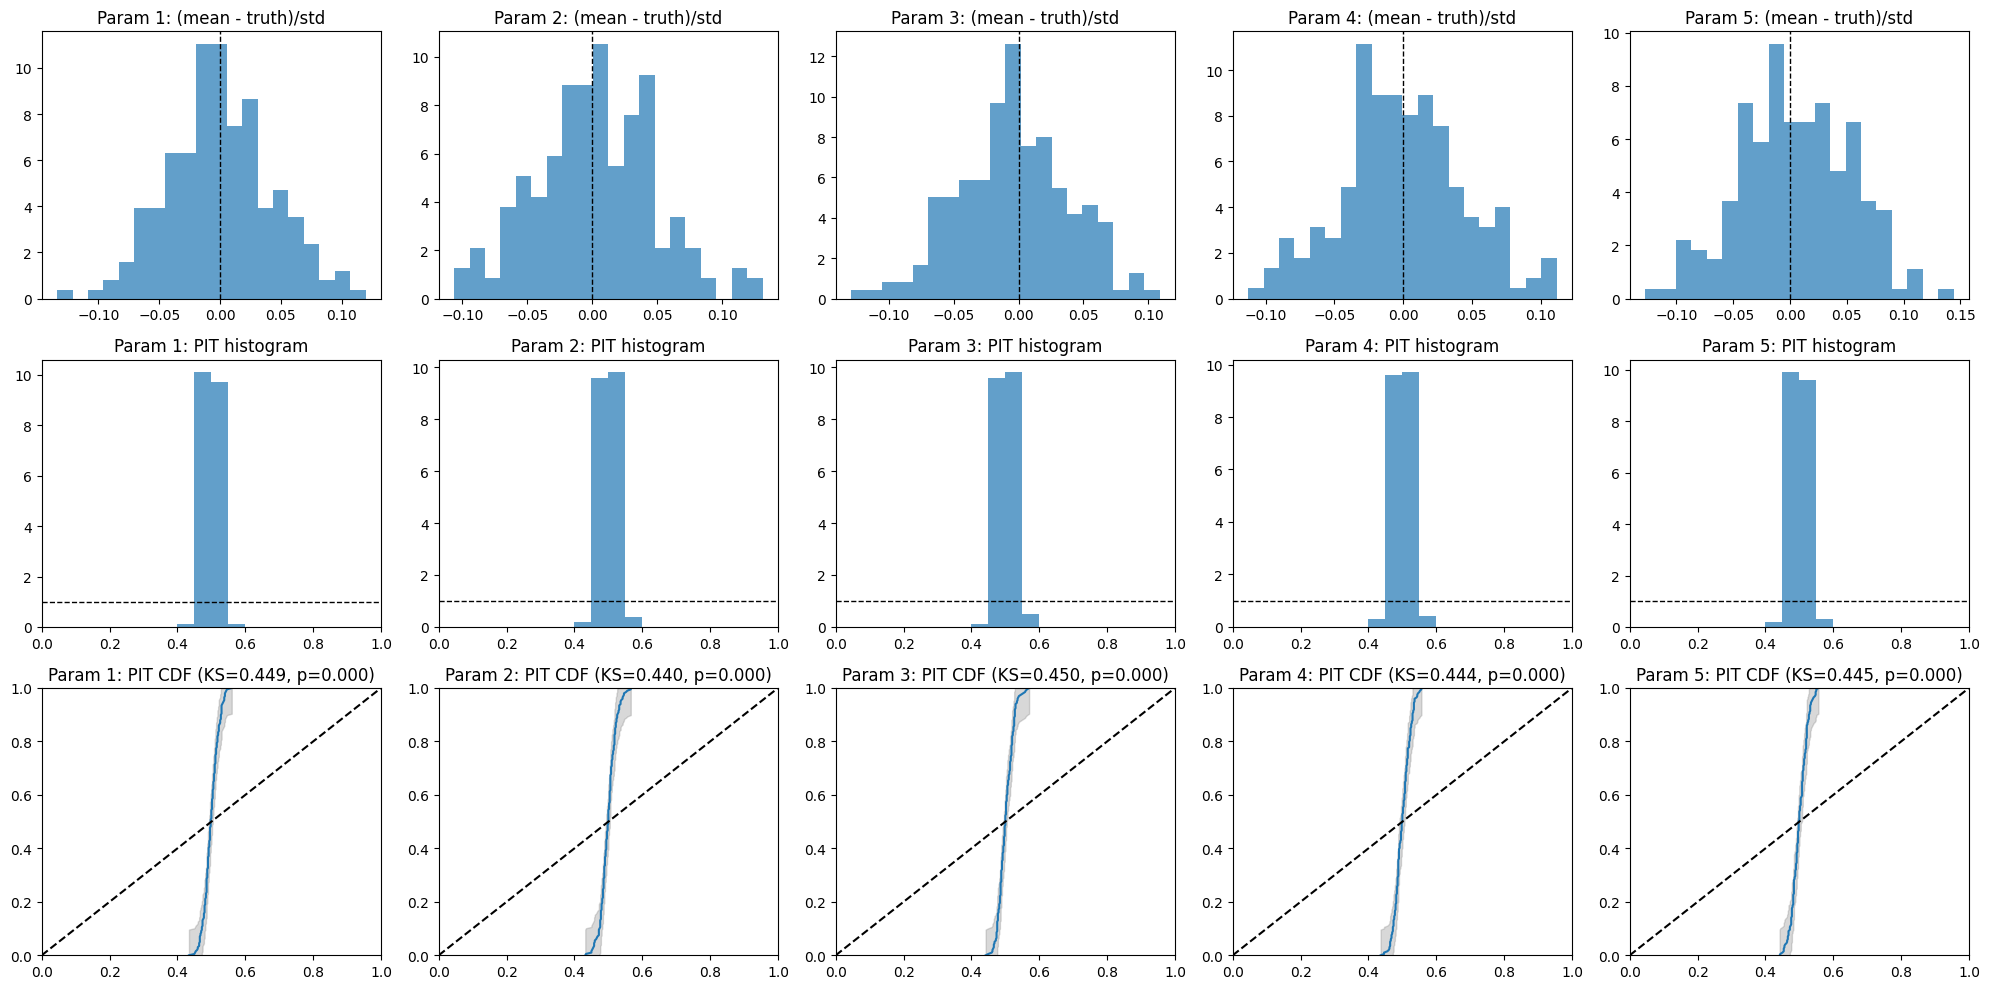

In [2]:
samples = np.random.randn(200, 500, 5) + np.array([0, 0.5, -1, 1, 2])
truth = np.array([[0, 0.5, -1, 1, 2]] * 200)

fig = plot_posterior_diagnostics(samples, truth)
plt.show()